<a href="https://colab.research.google.com/github/JatinderKumarChaurasia/DL_Assignment/blob/main/Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torchviz
!pip install torchmetrics
!pip install torch_directml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=c0d71db666c381f14b399865632b8bc9305e7cd9a383db4e616035c7f58cda73
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 5.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from numpy import vstack
from tqdm import tqdm
import time
import math,itertools
import torchmetrics
# import torch_directml
import torch
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader,TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, precision_score, average_precision_score,recall_score, f1_score
from sklearn.metrics import *
from sklearn.utils import class_weight
from torch import nn
from torch.nn import functional as F

**Check the GPU availability**

In [7]:
gpu = torch.cuda.is_available()
print(f"Is the GPU available? {gpu}")

Is the GPU available? False


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


**Mounting Drive**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Checking for missing values**

In [10]:
gdrive_path = '/content/drive/My Drive/data.csv'
df_data=pd.read_csv(gdrive_path)
df_data.columns
tmp = df_data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]
# no missing value



,index,missing_val


:**Print row number 49 to row 57 from input dataset along with its feature values**

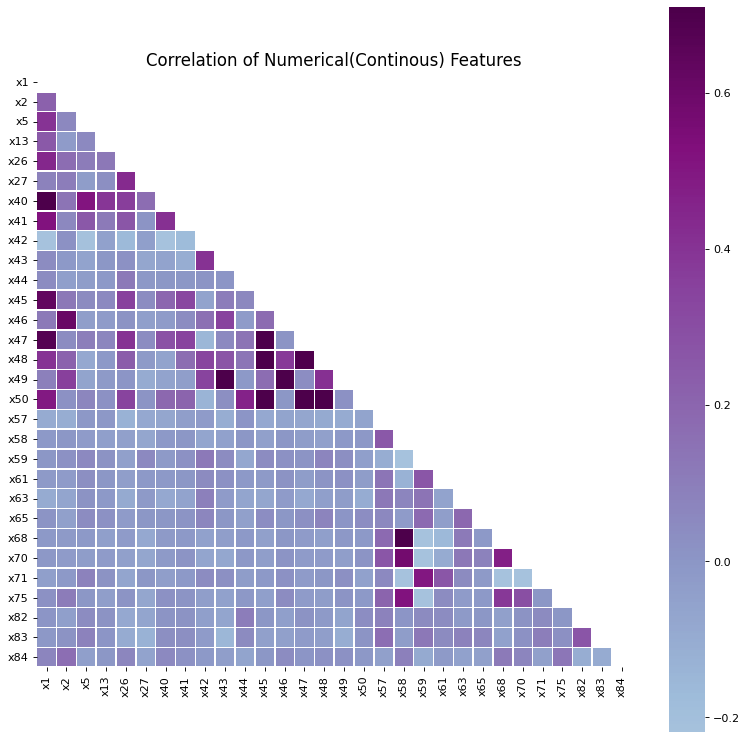

In [11]:
# my_csv.dropna()
# data=my_csv.drop(columns='T',inplace=True)
# target=my_csv.T
likely_cat = {}
for var in df_data.iloc[:,:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

#Taking all columns except URL 
corr = df_data[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of Numerical(Continous) Features', fontsize=15)
plt.show()

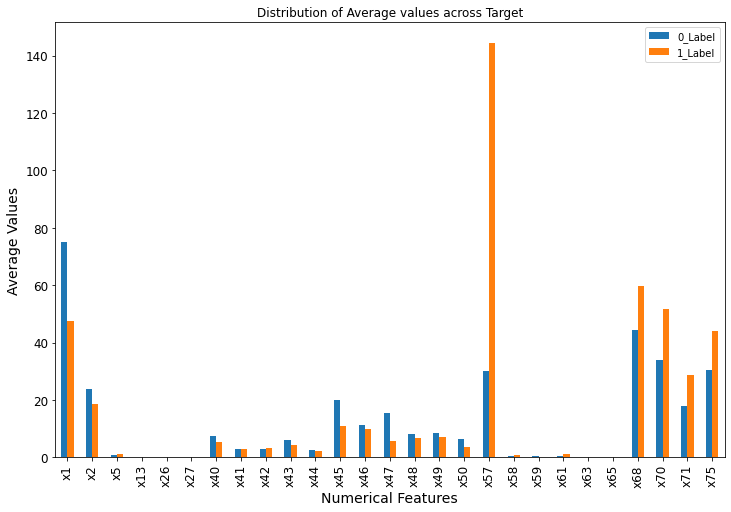

In [12]:
df_distr =df_data.groupby('T')[num_cols].mean().reset_index().T
df_distr.rename(columns={0:'0_Label',1:"1_Label"}, inplace=True)

#plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['0_Label','1_Label']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
#ax.set_ylim(0,500000)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


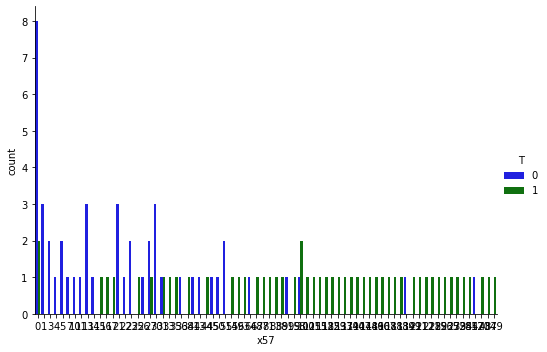

In [13]:
sns.catplot("x57", hue="T", data=df_data.head(100), kind="count",
            palette={1:"green", 0:"blue"} ,height=5.0, aspect=11.7/8.27 )

**Split the data into train set(80% of data points) and testset(20% of data)**

**Model Development**
**a) Build the Fully connected Deep Neural Network**
**b) Experiment with number of hidden layers, and number of neurons in the network**

In [50]:

# Data Preprocessing and Tensors Creations
class DataLine(Dataset):
  # scaled using MinMaxScalar
  def __init__(self,path=None,target_variable:str=None,do_split:bool=False,split_ratio:float=0.1,split_shuffle:bool=False,do_scale:bool=False,convert_to_tensor:bool=False):
    self.df_data=pd.read_csv(gdrive_path)
    self.preprocessed_data_frame=self.check_missing_values(self.check_nan_values(self.df_data))
    self.x= self.preprocessed_data_frame.drop([target_variable],axis=1) # features
    self.y = self.preprocessed_data_frame[[target_variable]] # target_variables = T
    self.split_ratio=split_ratio
    self.do_split= do_split
    self.do_scale= do_scale
    self.convert_to_tensor= convert_to_tensor
    self.split_shuffle=split_shuffle
    self.feature_set_columns,self.feature_set_shape= self.x.columns.values,self.x.shape
    self.test_set_columns,test_set_shape=self.y.columns,self.y.shape
    if self.do_split:
      self.train_x,self.test_x,self.train_y,self.test_y= self.split(test_ratio=self.split_ratio,shuffle=self.split_shuffle)
    else:
      self.train_x,self.test_x,self.train_y,self.test_y = None,None,None,None
    if self.do_scale and self.do_split:
      print('Scaling Training Data')
      scaler = preprocessing.MinMaxScaler()
      self.x_train = scaler.fit_transform(self.train_x.values)
      self.x_test =  scaler.fit_transform(self.test_x.values)
      # print("Scaled values of Train set and Type \n")
      # print(self.x_train,type(self.x_train))
      # print("\nScaled values of Test set and Type \n")
      # print(self.x_test,type(self.x_test))
    else:
      self.x_train,self.x_test=self.train_x,self.test_x
    if self.do_split and self.convert_to_tensor:
      print('Converting to tensor')
      self.x_tensor =  torch.from_numpy(self.x_train).float().to(device)
      self.y_tensor =  torch.from_numpy(self.train_y.values.ravel()).float().to(device)
      self.xtest_tensor =  torch.from_numpy(self.x_test).float().to(device)
      self.ytest_tensor =  torch.from_numpy(self.test_y.values.ravel()).float().to(device)
    else:
      self.x_tensor,self.y_tensor,self.xtest_tensor,self.ytest_tensor= None,None,None,None
    
    print("Feature Set Columns: {} and Shape: {}".format(self.x.columns,self.x.shape))
    print("Test_Variable Column: {} and Shape: {}".format(self.y.columns,self.y.shape))
    # self.x = torch.tensor(input_set.values,dtype=torch.float32)
    # self.y = torch.tensor(target_set.values,dtype=torch.float32)
    self.length = self.x.shape

  # def get_pre_processed_data(self,dataframe: pd.DataFrame):
  #   print('checking if there is null value')
  #   print(dataframe.isnull().sum().sum())
  #   return dataframe
  
  def check_missing_values(self,df_data):
    print('checking if any missing or invalid value in here')
    # print(df_data.isnull().sum().to_markdown())
    if df_data.isnull().sum().sum() == 0:
      print('No Missing Values Found in DataSet')
    else:
      df_data.interpolate(method='linear') # impute missing value
      df_data.fillna(0,inplace=True)
    # for i,j in self.df_data.isnull().sum().index():
    #   print(i,j)
    # print(self.df_data.isnull().sum().sum().to_markdown()) 
    return df_data

  def get_feature_columns(self):
    return self.x.columns

  def get_test_columns(self):
    return self.y.columns

  def check_nan_values(self,df_data):
    print('checking if any nan value in there')
    if df_data.isna().sum().sum() == 0:
      print('No Nan Values Found in DataSet')
    else:
      df_data.fillna(0,inplace=True)
    #filtered_tensor = self.x_tensor[~torch.any(self.x_tensor.isnan(),dim=1)]
    # print(filtered_tensor)
    # for i,j in self.df_data.isna().sum().index():
    #   print(i,j)
    # print(self.df_data.isna().sum().sum().to_markdown()) 
    return df_data

  def print_rows(self,from_row:int,to_row:int):
    print(f'Print row number {from_row} to row {to_row} from input dataset along with its feature values ')
    print(self.preprocessed_data_frame.iloc[from_row:to_row].to_markdown())

  def get_visuals(self):
    pass

  def pre_processing_data(self):
    pass
    
    
  def __getitem__(self, index):
      return self.x[index],self.y[index]
      # row = self.dataframe.iloc[index].to_numpy()
      # features = row[1:]
      # label = row[0]
      # return features, label

  def __len__(self):
      return len(self.x)

  def get_split_data(self):
    if self.do_split:
      return self.train_x,self.test_x,self.train_y,self.test_y
    else:
      raise Exception(f'Split is not done when processing dataset-> split is -> {self.do_split}')

  def split(self,test_ratio:float = 0.1,shuffle: bool = False):
    
    if test_ratio > 1 or test_ratio <= 0:
      raise Exception("Invalid test_ratio, need to be in between 0 and 1 , found ratio: {}".format(test_ratio))
    train_ratio= 1- test_ratio
    print("Splitting Train Ratio: {}, Test_Ratio: {}".format(train_ratio,test_ratio))
    train_x,test_x,train_y,test_y= train_test_split(self.x,self.y,test_size=test_ratio,train_size=train_ratio,shuffle=shuffle)
    print("TrainingSet_X Shape: {} \nTestSet_X Shape: {} \nTraining_Set_Y Shape: {} \nTest_Set_Y: {}".format(train_x.shape,test_x.shape,train_y.shape,test_y.shape))
    return train_x,test_x,train_y,test_y
    # if scale == True:
    #   print('Scaling Training Data')
    #   scaler = preprocessing.MinMaxScaler()
    #   x_train = scaler.fit_transform(train_x.values)
    #   x_test =  scaler.fit_transform(test_x.values)
    #   print("Scaled values of Train set and Type \n")
    #   print(x_train,type(x_train))
    #   print("\nScaled values of Test set and Type \n")
    #   print(x_test,type(x_test))
    # else:
    #   x_train,x_test= train_x,test_x
    # if convert_to_tensor == True:
    #   print('Converting to tensor')
    #   x_tensor =  torch.from_numpy(x_train).float()
    #   y_tensor =  torch.from_numpy(train_y.values.ravel()).float()
    #   xtest_tensor =  torch.from_numpy(x_test).float()
    #   ytest_tensor =  torch.from_numpy(test_y.values.ravel()).float()
    # else:
    #   x_tensor,y_tensor,xtest_tensor,ytest_tensor=x_train,train_y,x_test,test_y
    # return x_tensor,y_tensor,xtest_tensor,ytest_tensor


In [24]:
# To calculate Accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
def l1_l2_regularizer(regularizer_type,params,lambda_value=0.001):
  if regularizer_type == 'l1':
    norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
  elif regularizer_type == 'l2':
    norm= sum(torch.linalg.norm(p, 2) for p in model.parameters())
  else:
    raise Exception("Only l1 and l2 regularizer as regularizer_type")
  return lambda_value * norm

In [116]:
# loading csv
data_line = DataLine(path=gdrive_path,target_variable='T',do_split=True,split_ratio=0.2,convert_to_tensor=True,do_scale=True)


checking if any nan value in there
No Nan Values Found in DataSet
checking if any missing or invalid value in here
No Missing Values Found in DataSet
Splitting Train Ratio: 0.8, Test_Ratio: 0.2
TrainingSet_X Shape: (9144, 87) 
TestSet_X Shape: (2286, 87) 
Training_Set_Y Shape: (9144, 1) 
Test_Set_Y: (2286, 1)
Scaling Training Data
Converting to tensor
Feature Set Columns: Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41',
       'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51',
       'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61',
       'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71',
       'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81',
       'x82

In [48]:
# feature columns
data_line.get_feature_columns()

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41',
       'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51',
       'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61',
       'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71',
       'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81',
       'x82', 'x83', 'x84', 'x85', 'x86', 'x87'],
      dtype='object')

In [49]:
# test_columns:
data_line.get_test_columns()

Index(['T'], dtype='object')

In [44]:
# Splitted Data Set and their shapes - 20% test 
tr_x,tr_y,te_x,te_y = data_line.get_split_data()
print(f"Train X Set Shape: {tr_x.shape}")
print(f"Train Y Set Shape: {tr_y.shape}")
print(f"Test X Set Shape: {te_x.shape}")
print(f"Test Y Set Shape: {te_y.shape}")

Train X Set Shape: (9144, 87)
Train Y Set Shape: (2286, 87)
Test X Set Shape: (9144, 1)
Test Y Set Shape: (2286, 1)


In [52]:
# checking Nan Values
data_line.check_nan_values(data_line.df_data)

checking if any nan value in there
No Nan Values Found in DataSet


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x79,x80,x81,x82,x83,x84,x85,x86,x87,T
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,0
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,45,17,0,2,0,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,1
11426,84,18,0,5,0,1,1,0,0,1,...,1,0,0,211,6728,0,0,1,0,0
11427,105,16,1,2,6,0,1,0,0,1,...,0,0,0,2809,8515,8,0,1,10,1
11428,38,30,0,2,0,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,1


In [53]:
# checking missing values and perform imputation 
data_line.check_missing_values(data_line.df_data)

checking if any missing or invalid value in here
No Missing Values Found in DataSet


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x79,x80,x81,x82,x83,x84,x85,x86,x87,T
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,0
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,45,17,0,2,0,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,1
11426,84,18,0,5,0,1,1,0,0,1,...,1,0,0,211,6728,0,0,1,0,0
11427,105,16,1,2,6,0,1,0,0,1,...,0,0,0,2809,8515,8,0,1,10,1
11428,38,30,0,2,0,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,1


In [54]:
#Print row number 49 to row 57 from input dataset along with its feature values (0.5)
data_line.print_rows(49,57)

Print row number 49 to row 57 from input dataset along with its feature values 
|    |   x1 |   x2 |   x3 |   x4 |   x5 |   x6 |   x7 |   x8 |   x9 |   x10 |   x11 |   x12 |   x13 |   x14 |   x15 |   x16 |   x17 |   x18 |   x19 |   x20 |   x21 |   x22 |   x23 |   x24 |   x25 |       x26 |      x27 |   x28 |   x29 |   x30 |   x31 |   x32 |   x33 |   x34 |   x35 |   x36 |   x37 |   x38 |   x39 |   x40 |   x41 |   x42 |   x43 |   x44 |   x45 |   x46 |   x47 |      x48 |   x49 |      x50 |   x51 |   x52 |   x53 |   x54 |   x55 |   x56 |   x57 |      x58 |       x59 |   x60 |   x61 |   x62 |      x63 |   x64 |       x65 |   x66 |   x67 |      x68 |   x69 |      x70 |     x71 |   x72 |   x73 |   x74 |       x75 |   x76 |   x77 |   x78 |   x79 |   x80 |   x81 |   x82 |   x83 |             x84 |   x85 |   x86 |   x87 |   T |
|---:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------

In [55]:
# getting tensor dataset
x_tensor,y_tensor,xtest_tensor,ytest_tensor = data_line.x_tensor,data_line.y_tensor,data_line.xtest_tensor,data_line.ytest_tensor
# data_line.get_summary_of_dataset()
data_line.get_visuals()

print("\nTrain set Tensors \n")
print(x_tensor.shape)
print(y_tensor.shape)
print("\nTest set Tensors \n")
print(xtest_tensor.shape)
print(ytest_tensor.shape)


Train set Tensors 

torch.Size([9144, 87])
torch.Size([9144])

Test set Tensors 

torch.Size([2286, 87])
torch.Size([2286])


In [57]:
# Creating Tensor DataSets
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches



#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)


In [70]:
# Loading Datasets using DataLoader
train_dl = DataLoader(train_ds, batch_size=87)
test_loader = DataLoader(test_ds, batch_size=87)

In [125]:
# Binary Classification Model
# from torch import nn
# from torch.nn import functional as F

# Build the Fully connected Deep Neural Network 
# TODO: CREATE NEURAL NETWORK MODULE
class Net(nn.Module):
  def __init__(self,input_nodes,hidden1,hidden2,output):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_nodes,hidden1)
    self.fc2 = nn.Linear(hidden1,hidden2)
    self.fc3 = nn.Linear(hidden2,output)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

class BinaryClassification(nn.Module):
    def __init__(self,input_nodes,hidden1,hidden2,output):
        super(BinaryClassification, self).__init__()
        print(dimensions_of_training_set)
        self.layer_1 = nn.Linear(input_nodes, hidden1) 
        self.layer_2 = nn.Linear(hidden1, hidden2)
        self.layer_out = nn.Linear(hidden2, output) 
        
        
        self.relu = nn.ReLU() # activation function
        self.sigmoid =  nn.Sigmoid() # to give the single output
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(hidden1) # normalization 1d after do first layer
        self.batchnorm2 = nn.BatchNorm1d(hidden2) # normalization 1d after do after second layer
        
        
    def forward(self, inputs):
      # softmax ,leakyrelu,
        x = self.relu(self.layer_1(inputs)) # activation function
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x)) # activation function
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x)) # activation function
        return x

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()

    def compute_l2_loss(self, w):
      return torch.square(w).sum()
 
    

In [113]:
# trainloader = DataLoader(data_line,batch_size=64,shuffle=False)
dimensions_of_training_set=data_line.train_x.shape[1]
# print(dimensions_of_training_set)
n_hidden1 = 174  # Number of hidden nodes
n_hidden2 = 348
n_output =  1   # Number of output nodes = for binary classifier
decay =0.1


learning_rate=0.1  
def build_model(model_type=1,hidden1=144,hidden2=100,optimizer='adam',use_regularizer=True,decay=0.1,learning_rate=0.1):
  # TODO: add modules here
    if not use_regularizer:
      decay=0
    if model_type ==1:
      model = Net(dimensions_of_training_set,hidden1,hidden2,n_output)
    elif model_type == 2:
      model = BinaryClassification(dimensions_of_training_set,hidden1,hidden2,n_output)
    loss_fn = nn.BCELoss()
    if optimizer == 'adam':
      optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=decay)
    elif optimizer == 'sgd':
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay=decay)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay)
    return model, loss_fn,optimizer

def accuracy(logits, labels):
    acc = torchmetrics.functional.classification.accuracy(logits, labels,'binary')
    return acc

def train(dataloader, model, device, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print(size)
    model = model.to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        # _, preduc = torch.max(pred, 1)
        # print(preduc.shape)
        # print(y.shape)
        loss = loss_fn(pred.unsqueeze(1),y)
        # loss = loss_fn(pred,y)
        acc = accuracy(pred.unsqueeze(1), y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, acc, current = loss.item(), acc.item(), batch * len(X)
            print(f"Train: loss: {loss:>7f} - acc: {acc:>7f}  [{current:>5d}/{size:>5d}]")

    model = model.to(device)
    return loss.item(),acc.item()

def test(dataloader, model, device, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model = model.to(device)
    model.eval()
    test_loss, correct,acc = 0, 0,0
    # for confusion matrix
    predictions=[]
    actuals=[]
    predict=None
    actual=None
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            acc+= accuracy(pred.unsqueeze(1), y)
            # _, preduc = torch.max(pred, 1)
            test_loss += loss_fn(pred.unsqueeze(1), y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            y_pred_tag = torch.round(pred)
            predict=y_pred_tag.cpu().detach().numpy()
            actual=y.cpu().numpy().reshape((len(y.cpu().numpy()), 1))
    test_loss /= num_batches
    correct /= size
    acc /= num_batches
    # print(acc)
    # print(f"Test Error: \n Accuracy: {(correct)*100:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    model = model.to(device)
    return test_loss,acc.item(),predict,actual

def train_test_loop(model_type=1,epochs=50,hidden1=144,hidden2=100,optimizer='adam',use_regularizer=True,decay=0.1,learning_rate=0.1,evaluate=True,learning_curve=False):
  model, loss_fn,optimizer = build_model(model_type=model_type,hidden1=hidden1,hidden2=hidden1,optimizer=optimizer,use_regularizer=use_regularizer,decay=decay,learning_rate=learning_rate)
  print(model)
  test_acc=[]
  test_loss=[]
  train_acc=[]
  train_loss=[]
  predicts=[]
  actuals=[]
  for t in tqdm(range(epochs)):
    train_los,train_ac=train(train_dl, model, device, loss_fn, optimizer)
    train_acc.append(train_ac)
    train_loss.append(train_los)
    print(f'Train => Model_accuracy: {np.average(train_acc)} | Model Loss: {np.average(train_loss)}')
    if evaluate:
      test_los,test_ac,predict,actual=test(test_loader,model,device,loss_fn)
      print(f'Test => Model_accuracy: {np.average(test_ac)} | Model Loss: {np.average(test_los)}')
      test_loss.append(test_los)
      test_acc.append(test_ac)
      predicts.append(predict)
      actuals.append(actual)
  
  # if len(actuals) > 0 or len(predicts) > 0:
  #   print(actuals)
    # cm = confusion_matrix(actuals,predicts)
  print("----------------------------------------------------------------------------------------------")
  print(f"Final Train Accuracy: {np.average(train_acc)} | Final Train Loss: {np.average(train_loss)}")
  print(f"Final Test Accuracy: {np.average(test_acc)} | Final Test Loss: {np.average(test_loss)}")
  
  if evaluate and learning_curve:
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    ax1.plot( train_acc, label="train_accuracy")
    ax1.plot(test_acc, label="test_accuracy")
    ax1.legend(loc=2)
    ax2.plot(train_loss, label="train_loss")
    ax2.plot(test_loss, label="test_loss")
    ax2.legend(loc=2)
    # plt.plot(final_train_accuracy_list,final_test_accuracy_list)
    plt.show()
      
    # print("test_accuracy: {} | test_loss: {}".format(test_ac.item(),test_los))


In [117]:
# Experiment with number of hidden layers, and number of neurons in the network
train_test_loop(model_type=2,epochs=50,hidden1=174,hidden2=348,optimizer='adam',use_regularizer=False,decay=0.1,learning_rate=0.1,evaluate=False,learning_curve=True)


87
BinaryClassification(
  (layer_1): Linear(in_features=87, out_features=174, bias=True)
  (layer_2): Linear(in_features=174, out_features=174, bias=True)
  (layer_out): Linear(in_features=174, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(174, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(174, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


  0%|          | 0/50 [00:00<?, ?it/s]

9144
Train: loss: 0.701177 - acc: 0.574713  [    0/ 9144]


  2%|▏         | 1/50 [00:01<01:01,  1.25s/it]

Train: loss: 0.169197 - acc: 0.977012  [ 8700/ 9144]
Train => Model_accuracy: 0.8888888955116272 | Model Loss: 0.17849162220954895
9144
Train: loss: 0.151058 - acc: 0.954023  [    0/ 9144]


  4%|▍         | 2/50 [00:02<00:47,  1.00it/s]

Train: loss: 0.181968 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9444444477558136 | Model Loss: 0.13417720794677734
9144
Train: loss: 0.100901 - acc: 0.965517  [    0/ 9144]


  6%|▌         | 3/50 [00:02<00:44,  1.05it/s]

Train: loss: 0.142449 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9629629651705424 | Model Loss: 0.11530042191346486
9144
Train: loss: 0.100394 - acc: 0.965517  [    0/ 9144]


  8%|▊         | 4/50 [00:03<00:44,  1.03it/s]

Train: loss: 0.149585 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9722222238779068 | Model Loss: 0.09926821570843458
9144
Train: loss: 0.075071 - acc: 0.977012  [    0/ 9144]


 10%|█         | 5/50 [00:04<00:40,  1.11it/s]

Train: loss: 0.176131 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9777777791023254 | Model Loss: 0.10106918290257454
9144
Train: loss: 0.110704 - acc: 0.965517  [    0/ 9144]


 12%|█▏        | 6/50 [00:05<00:35,  1.26it/s]

Train: loss: 0.135685 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9629629651705424 | Model Loss: 0.11992163769900799
9144
Train: loss: 0.052016 - acc: 1.000000  [    0/ 9144]


 14%|█▍        | 7/50 [00:05<00:28,  1.50it/s]

Train: loss: 0.137473 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9682539701461792 | Model Loss: 0.11549992912581988
9144
Train: loss: 0.055070 - acc: 0.988506  [    0/ 9144]


 16%|█▌        | 8/50 [00:06<00:25,  1.65it/s]

Train: loss: 0.119407 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9722222238779068 | Model Loss: 0.10865469044074416
9144
Train: loss: 0.045503 - acc: 1.000000  [    0/ 9144]


 18%|█▊        | 9/50 [00:06<00:22,  1.79it/s]

Train: loss: 0.184719 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9753086434470283 | Model Loss: 0.11088226363062859
9144
Train: loss: 0.050706 - acc: 0.988506  [    0/ 9144]


 20%|██        | 10/50 [00:07<00:21,  1.85it/s]

Train: loss: 0.146626 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9777777791023254 | Model Loss: 0.11037153638899326
9144
Train: loss: 0.059061 - acc: 0.988506  [    0/ 9144]


 22%|██▏       | 11/50 [00:07<00:19,  1.96it/s]

Train: loss: 0.136644 - acc: 0.977012  [ 8700/ 9144]
Train => Model_accuracy: 0.979797981002114 | Model Loss: 0.1077029870992357
9144
Train: loss: 0.050115 - acc: 1.000000  [    0/ 9144]


 24%|██▍       | 12/50 [00:08<00:18,  2.02it/s]

Train: loss: 0.141297 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9814814825852712 | Model Loss: 0.10554988216608763
9144
Train: loss: 0.062529 - acc: 0.988506  [    0/ 9144]


 26%|██▌       | 13/50 [00:08<00:18,  2.05it/s]

Train: loss: 0.092285 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9829059839248657 | Model Loss: 0.10171500106270497
9144
Train: loss: 0.052155 - acc: 1.000000  [    0/ 9144]


 28%|██▊       | 14/50 [00:09<00:17,  2.06it/s]

Train: loss: 0.127848 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.9841269850730896 | Model Loss: 0.0971204766205379
9144
Train: loss: 0.049287 - acc: 0.988506  [    0/ 9144]


 30%|███       | 15/50 [00:09<00:17,  2.02it/s]

Train: loss: 0.141022 - acc: 0.977012  [ 8700/ 9144]
Train => Model_accuracy: 0.9629629651705424 | Model Loss: 0.13121033906936647
9144
Train: loss: 0.020119 - acc: 1.000000  [    0/ 9144]


 32%|███▏      | 16/50 [00:10<00:17,  2.00it/s]

Train: loss: 0.136540 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9652777798473835 | Model Loss: 0.12394267902709544
9144
Train: loss: 0.055532 - acc: 0.988506  [    0/ 9144]


 34%|███▍      | 17/50 [00:10<00:16,  2.01it/s]

Train: loss: 0.203944 - acc: 0.942529  [ 8700/ 9144]
Train => Model_accuracy: 0.9673202633857727 | Model Loss: 0.11782483011484146
9144
Train: loss: 0.041018 - acc: 0.988506  [    0/ 9144]


 36%|███▌      | 18/50 [00:10<00:15,  2.08it/s]

Train: loss: 0.141926 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9691358043087853 | Model Loss: 0.11171549449985226
9144
Train: loss: 0.027675 - acc: 1.000000  [    0/ 9144]


 38%|███▊      | 19/50 [00:11<00:15,  2.05it/s]

Train: loss: 0.180321 - acc: 0.942529  [ 8700/ 9144]
Train => Model_accuracy: 0.9707602356609545 | Model Loss: 0.10625127673541244
9144
Train: loss: 0.038562 - acc: 0.988506  [    0/ 9144]


 40%|████      | 20/50 [00:11<00:14,  2.06it/s]

Train: loss: 0.298933 - acc: 0.931035  [ 8700/ 9144]
Train => Model_accuracy: 0.9722222238779068 | Model Loss: 0.10099010200356133
9144
Train: loss: 0.039290 - acc: 0.988506  [    0/ 9144]


 42%|████▏     | 21/50 [00:12<00:14,  2.07it/s]

Train: loss: 0.142920 - acc: 0.977012  [ 8700/ 9144]
Train => Model_accuracy: 0.973544975121816 | Model Loss: 0.096862295537167
9144
Train: loss: 0.006656 - acc: 1.000000  [    0/ 9144]


 44%|████▍     | 22/50 [00:12<00:13,  2.07it/s]

Train: loss: 0.161040 - acc: 0.977012  [ 8700/ 9144]
Train => Model_accuracy: 0.9747474762526426 | Model Loss: 0.09291779523482546
9144
Train: loss: 0.040254 - acc: 0.988506  [    0/ 9144]


 46%|████▌     | 23/50 [00:13<00:12,  2.10it/s]

Train: loss: 0.122142 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.975845412067745 | Model Loss: 0.091148211119656
9144
Train: loss: 0.051280 - acc: 0.988506  [    0/ 9144]


 48%|████▊     | 24/50 [00:13<00:12,  2.15it/s]

Train: loss: 0.287723 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.976851853231589 | Model Loss: 0.08737939377412356
9144
Train: loss: 0.141843 - acc: 0.942529  [    0/ 9144]


 50%|█████     | 25/50 [00:14<00:11,  2.18it/s]

Train: loss: 0.253010 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9777777791023254 | Model Loss: 0.08492007261607797
9144
Train: loss: 0.066384 - acc: 0.977012  [    0/ 9144]


 52%|█████▏    | 26/50 [00:14<00:10,  2.21it/s]

Train: loss: 0.216492 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9786324799060822 | Model Loss: 0.08225691976258531
9144
Train: loss: 0.066032 - acc: 0.965517  [    0/ 9144]


 54%|█████▍    | 27/50 [00:15<00:10,  2.22it/s]

Train: loss: 0.659170 - acc: 0.942529  [ 8700/ 9144]
Train => Model_accuracy: 0.9794238695391903 | Model Loss: 0.07932908228960717
9144
Train: loss: 0.766780 - acc: 0.919540  [    0/ 9144]


 56%|█████▌    | 28/50 [00:15<00:09,  2.21it/s]

Train: loss: 0.199966 - acc: 0.954023  [ 8700/ 9144]
Train => Model_accuracy: 0.980158731341362 | Model Loss: 0.0778070421116094
9144
Train: loss: 0.039740 - acc: 0.988506  [    0/ 9144]


 58%|█████▊    | 29/50 [00:16<00:09,  2.23it/s]

Train: loss: 0.095750 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9808429130192461 | Model Loss: 0.07643886041779328
9144
Train: loss: 0.043690 - acc: 0.977012  [    0/ 9144]


 60%|██████    | 30/50 [00:16<00:09,  2.20it/s]

Train: loss: 0.130866 - acc: 0.977012  [ 8700/ 9144]
Train => Model_accuracy: 0.9814814825852712 | Model Loss: 0.07403025165743506
9144
Train: loss: 0.036842 - acc: 0.977012  [    0/ 9144]


 62%|██████▏   | 31/50 [00:16<00:08,  2.22it/s]

Train: loss: 0.073892 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9820788541147786 | Model Loss: 0.07203532990834285
9144
Train: loss: 0.042986 - acc: 0.988506  [    0/ 9144]


 64%|██████▍   | 32/50 [00:17<00:08,  2.17it/s]

Train: loss: 0.076136 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9826388899236917 | Model Loss: 0.07017550109230797
9144
Train: loss: 0.037279 - acc: 0.977012  [    0/ 9144]


 66%|██████▌   | 33/50 [00:17<00:07,  2.18it/s]

Train: loss: 0.120509 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9831649841684283 | Model Loss: 0.0682201006866032
9144
Train: loss: 0.036930 - acc: 0.977012  [    0/ 9144]


 68%|██████▊   | 34/50 [00:18<00:07,  2.16it/s]

Train: loss: 0.104246 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9836601316928864 | Model Loss: 0.0677791407215409
9144
Train: loss: 0.012299 - acc: 1.000000  [    0/ 9144]


 70%|███████   | 35/50 [00:18<00:06,  2.15it/s]

Train: loss: 0.099444 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9841269850730896 | Model Loss: 0.06692347586088415
9144
Train: loss: 0.042896 - acc: 0.977012  [    0/ 9144]


 72%|███████▏  | 36/50 [00:19<00:06,  2.10it/s]

Train: loss: 0.095313 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9845679021543927 | Model Loss: 0.06542854190532428
9144
Train: loss: 0.025791 - acc: 0.988506  [    0/ 9144]


 74%|███████▍  | 37/50 [00:19<00:06,  2.06it/s]

Train: loss: 0.081618 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9849849858799496 | Model Loss: 0.06369776235943711
9144
Train: loss: 0.024928 - acc: 0.988506  [    0/ 9144]


 76%|███████▌  | 38/50 [00:20<00:05,  2.07it/s]

Train: loss: 0.055517 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9853801178304773 | Model Loss: 0.062063260834149425
9144
Train: loss: 0.051757 - acc: 0.977012  [    0/ 9144]


 78%|███████▊  | 39/50 [00:20<00:05,  2.10it/s]

Train: loss: 0.078236 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9829059839248657 | Model Loss: 0.06271848058363852
9144
Train: loss: 0.028128 - acc: 0.988506  [    0/ 9144]


 80%|████████  | 40/50 [00:21<00:04,  2.10it/s]

Train: loss: 0.086130 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9833333343267441 | Model Loss: 0.06212081075354945
9144
Train: loss: 0.043238 - acc: 0.988506  [    0/ 9144]


 82%|████████▏ | 41/50 [00:21<00:04,  2.08it/s]

Train: loss: 0.120444 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9837398383675552 | Model Loss: 0.060890477238699975
9144
Train: loss: 0.062540 - acc: 0.977012  [    0/ 9144]


 84%|████████▍ | 42/50 [00:22<00:03,  2.08it/s]

Train: loss: 0.058282 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9841269850730896 | Model Loss: 0.059666575506396057
9144
Train: loss: 0.079262 - acc: 0.965517  [    0/ 9144]


 86%|████████▌ | 43/50 [00:22<00:03,  2.05it/s]

Train: loss: 0.107200 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9844961249551107 | Model Loss: 0.05864981098133031
9144
Train: loss: 0.031756 - acc: 0.977012  [    0/ 9144]


 88%|████████▊ | 44/50 [00:23<00:02,  2.04it/s]

Train: loss: 0.109685 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9848484857515856 | Model Loss: 0.057821100405734877
9144
Train: loss: 0.018463 - acc: 0.988506  [    0/ 9144]


 90%|█████████ | 45/50 [00:23<00:02,  2.06it/s]

Train: loss: 0.151828 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9851851860682169 | Model Loss: 0.056537294955584606
9144
Train: loss: 0.020682 - acc: 0.988506  [    0/ 9144]


 92%|█████████▏| 46/50 [00:24<00:01,  2.03it/s]

Train: loss: 0.035158 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.985507247240647 | Model Loss: 0.05668151644733924
9144
Train: loss: 0.029806 - acc: 0.988506  [    0/ 9144]


 94%|█████████▍| 47/50 [00:24<00:01,  2.02it/s]

Train: loss: 0.093495 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9858156036823353 | Model Loss: 0.05549994914690615
9144
Train: loss: 0.023474 - acc: 0.988506  [    0/ 9144]


 96%|█████████▌| 48/50 [00:25<00:01,  1.95it/s]

Train: loss: 0.173140 - acc: 0.988506  [ 8700/ 9144]
Train => Model_accuracy: 0.9861111119389534 | Model Loss: 0.05434472916484386
9144
Train: loss: 0.020749 - acc: 0.988506  [    0/ 9144]


 98%|█████████▊| 49/50 [00:25<00:00,  1.99it/s]

Train: loss: 0.045872 - acc: 0.977012  [ 8700/ 9144]
Train => Model_accuracy: 0.9863945586340768 | Model Loss: 0.053532305452512335
9144
Train: loss: 0.012892 - acc: 1.000000  [    0/ 9144]


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]

Train: loss: 0.233065 - acc: 0.965517  [ 8700/ 9144]
Train => Model_accuracy: 0.9866666674613953 | Model Loss: 0.05246189220913948
----------------------------------------------------------------------------------------------
Final Train Accuracy: 0.9866666674613953 | Final Train Loss: 0.05246189220913948
Final Test Accuracy: nan | Final Test Loss: nan



/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [118]:
# trainloader = DataLoader(data_line,batch_size=64,shuffle=False)
dimensions_of_training_set=data_line.train_x.shape[1]
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier

learning_rate=0.2   
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassification(dimensions_of_training_set,n_hidden1,n_hidden2,n_output).to(device)
model2 = Net(dimensions_of_training_set,n_hidden1,n_hidden2,n_output)
print(model2)
y=model(train_ds.tensors[0]).to(device)
print(y.mean())
s=make_dot(y.mean(), params=dict(model.named_parameters()))
s.render()
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()
print(model)

87
Net(
  (fc1): Linear(in_features=87, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
tensor(0.5192, grad_fn=<MeanBackward0>)
BinaryClassification(
  (layer_1): Linear(in_features=87, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
# print(data_line.train_y)
# weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(data_line.train_y), y=data_line.train_y)
# # weight = {i : weight[i] for i in np.unique(data_line.train_y)}
# weight

In [121]:
# Training Model
final_train_accuracy_list=[]
final_train_loss_list=[]
def train_model(train_dl, model, epochs=50, lr=1e-5,regularizer='l1',l1_l2_weight=0.5,weight_decay=0 ,momentum=0.9, save_path='datapredemo.pth'):
    # Define your optimisation function for reducing loss when weights are calculated 
    # and propogated through the network
    best_accuracy=0.0
    start = time.time()
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    loss = 0.0
    train_loss_list = []
    train_accuracy_list =[]
    print('Beginning Training')
    for epoch in tqdm(range(epochs)):
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        print('-' * 10)
        model.train()
        # Iterate through training data loader
        for i, (inputs, outputs) in enumerate(train_dl):
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            _, preds = torch.max(predicted_outputs.data,1) #Get the class labels
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            train_loss = loss_function(predicted_outputs.unsqueeze(1), outputs) # model.compute_l1_loss(torch.cat(parameters)) * l1_l2_weight # + (l1_l2_weight* torch.cat([parameter.view(-1) for parameter in model.parameters()]))
            
            # print(torch.cat(parameters))
            # print(model.compute_l1_loss(torch.cat(parameters)) * l1_l2_weight)
      # l1 = l1_weight * mlp.compute_l1_loss(torch.cat(parameters))
      # l2 = l2_weight * mlp.compute_l2_loss(torch.cat(parameters))
            train_accuracy= binary_acc(predicted_outputs.unsqueeze(1), outputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss +=train_loss.item()
            running_accuracy+=train_accuracy.item()
            # accur.append(acc)
            # print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
        
        train_loss_value = running_train_loss/len(train_dl) 
        train_accuracy_value =running_accuracy/len(train_dl)
        print(f'Epoch {epoch+0:03}: | Loss: {train_loss_value:.5f} | Acc: {train_accuracy_value:.3f}')
        print('Epoch {}/{} and Last loss: {} and Last Accuracy: {} and train_loss_value: {}'.format(epoch+1, epochs,train_loss.item(),train_accuracy.item(),train_loss_value))
        train_loss_list.append(train_loss_value)
        train_accuracy_list.append(train_accuracy_value)

    print('Last iteration loss value: '+str(train_loss.item()))
    print('Last Iteration Accuracy Value: {}'.format(train_accuracy.item()))
    time_delta = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_delta // 60, time_delta % 60
    ))
    final_train_accuracy_list.extend(train_accuracy_list)
    final_train_loss_list.extend(train_loss_list)
    plt.plot(train_loss_list)

    print(train_accuracy_list)
    plt.show()
    plt.plot(train_accuracy_list)
    plt.show()
    return model

Beginning Training


  0%|          | 0/50 [00:00<?, ?it/s]

----------


  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

Epoch 000: | Loss: 0.56857 | Acc: 85.613
Epoch 1/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5685692350819426
----------


  4%|▍         | 2/50 [00:01<00:25,  1.86it/s]

Epoch 001: | Loss: 0.56180 | Acc: 87.981
Epoch 2/50 and Last loss: 0.48209965229034424 and Last Accuracy: 89.0 and train_loss_value: 0.5617972935708064
----------


  6%|▌         | 3/50 [00:01<00:31,  1.51it/s]

Epoch 002: | Loss: 0.56811 | Acc: 86.519
Epoch 3/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5681112869730536
----------


  8%|▊         | 4/50 [00:02<00:29,  1.59it/s]

Epoch 003: | Loss: 0.56192 | Acc: 87.726
Epoch 4/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5619203316153221
----------


 10%|█         | 5/50 [00:03<00:28,  1.55it/s]

Epoch 004: | Loss: 0.55600 | Acc: 89.679
Epoch 5/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5560047421252953
----------


 12%|█▏        | 6/50 [00:03<00:29,  1.51it/s]

Epoch 005: | Loss: 0.56337 | Acc: 87.311
Epoch 6/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5633725793856494
----------


 14%|█▍        | 7/50 [00:04<00:27,  1.54it/s]

Epoch 006: | Loss: 0.55195 | Acc: 90.028
Epoch 7/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5519479943333931
----------


 16%|█▌        | 8/50 [00:05<00:26,  1.56it/s]

Epoch 007: | Loss: 0.55966 | Acc: 88.670
Epoch 8/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5596562196623605
----------


 18%|█▊        | 9/50 [00:05<00:25,  1.58it/s]

Epoch 008: | Loss: 0.56341 | Acc: 85.538
Epoch 9/50 and Last loss: 0.5243092179298401 and Last Accuracy: 78.0 and train_loss_value: 0.5634059248105535
----------


 20%|██        | 10/50 [00:06<00:25,  1.55it/s]

Epoch 009: | Loss: 0.55801 | Acc: 88.915
Epoch 10/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5580057558023704
----------


 22%|██▏       | 11/50 [00:07<00:27,  1.44it/s]

Epoch 010: | Loss: 0.55627 | Acc: 90.038
Epoch 11/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5562690901306441
----------


 24%|██▍       | 12/50 [00:08<00:28,  1.33it/s]

Epoch 011: | Loss: 0.55486 | Acc: 89.113
Epoch 12/50 and Last loss: 0.5665186643600464 and Last Accuracy: 67.0 and train_loss_value: 0.5548593744916736
----------


 26%|██▌       | 13/50 [00:08<00:27,  1.33it/s]

Epoch 012: | Loss: 0.56555 | Acc: 86.981
Epoch 13/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.565554436647667
----------


 28%|██▊       | 14/50 [00:09<00:27,  1.31it/s]

Epoch 013: | Loss: 0.56980 | Acc: 87.613
Epoch 14/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5698041196139354
----------


 30%|███       | 15/50 [00:10<00:27,  1.28it/s]

Epoch 014: | Loss: 0.56318 | Acc: 88.255
Epoch 15/50 and Last loss: 0.6087281703948975 and Last Accuracy: 56.0 and train_loss_value: 0.5631807710764543
----------


 32%|███▏      | 16/50 [00:10<00:24,  1.38it/s]

Epoch 015: | Loss: 0.56478 | Acc: 85.764
Epoch 16/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5647805501829903
----------


 34%|███▍      | 17/50 [00:11<00:21,  1.51it/s]

Epoch 016: | Loss: 0.57295 | Acc: 87.679
Epoch 17/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5729493327298254
----------


 36%|███▌      | 18/50 [00:12<00:20,  1.60it/s]

Epoch 017: | Loss: 0.55598 | Acc: 89.415
Epoch 18/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5559787224486189
----------


 38%|███▊      | 19/50 [00:12<00:18,  1.68it/s]

Epoch 018: | Loss: 0.55357 | Acc: 89.830
Epoch 19/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5535701735402053
----------


 40%|████      | 20/50 [00:13<00:17,  1.74it/s]

Epoch 019: | Loss: 0.55380 | Acc: 89.840
Epoch 20/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5538015936343175
----------


 42%|████▏     | 21/50 [00:13<00:15,  1.82it/s]

Epoch 020: | Loss: 0.55626 | Acc: 89.434
Epoch 21/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5562582898814723
----------


 44%|████▍     | 22/50 [00:14<00:15,  1.83it/s]

Epoch 021: | Loss: 0.56707 | Acc: 88.028
Epoch 22/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5670729020856461
----------


 46%|████▌     | 23/50 [00:14<00:14,  1.89it/s]

Epoch 022: | Loss: 0.55598 | Acc: 89.358
Epoch 23/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5559766166052729
----------


 48%|████▊     | 24/50 [00:15<00:14,  1.85it/s]

Epoch 023: | Loss: 0.55728 | Acc: 88.472
Epoch 24/50 and Last loss: 0.6087281703948975 and Last Accuracy: 56.0 and train_loss_value: 0.557278426188343
----------


 50%|█████     | 25/50 [00:15<00:13,  1.86it/s]

Epoch 024: | Loss: 0.58152 | Acc: 81.679
Epoch 25/50 and Last loss: 0.6776297688484192 and Last Accuracy: 44.0 and train_loss_value: 0.5815195649299981
----------


 52%|█████▏    | 26/50 [00:16<00:12,  1.93it/s]

Epoch 025: | Loss: 0.58044 | Acc: 81.566
Epoch 26/50 and Last loss: 0.5665186643600464 and Last Accuracy: 67.0 and train_loss_value: 0.5804405516048647
----------


 54%|█████▍    | 27/50 [00:16<00:12,  1.88it/s]

Epoch 026: | Loss: 0.56957 | Acc: 84.623
Epoch 27/50 and Last loss: 0.5243091583251953 and Last Accuracy: 78.0 and train_loss_value: 0.5695690833172709
----------


 56%|█████▌    | 28/50 [00:17<00:11,  1.90it/s]

Epoch 027: | Loss: 0.56154 | Acc: 87.500
Epoch 28/50 and Last loss: 0.5243091583251953 and Last Accuracy: 78.0 and train_loss_value: 0.5615403579091126
----------


 58%|█████▊    | 29/50 [00:17<00:10,  1.96it/s]

Epoch 028: | Loss: 0.56147 | Acc: 87.425
Epoch 29/50 and Last loss: 0.5243091583251953 and Last Accuracy: 78.0 and train_loss_value: 0.5614673394077229
----------


 60%|██████    | 30/50 [00:18<00:10,  1.95it/s]

Epoch 029: | Loss: 0.56076 | Acc: 87.481
Epoch 30/50 and Last loss: 0.5665186643600464 and Last Accuracy: 67.0 and train_loss_value: 0.5607628063210901
----------


 62%|██████▏   | 31/50 [00:18<00:09,  1.91it/s]

Epoch 030: | Loss: 0.56031 | Acc: 87.632
Epoch 31/50 and Last loss: 0.5665186643600464 and Last Accuracy: 67.0 and train_loss_value: 0.5603093583628816
----------


 64%|██████▍   | 32/50 [00:19<00:09,  1.86it/s]

Epoch 031: | Loss: 0.56703 | Acc: 85.472
Epoch 32/50 and Last loss: 0.6087281703948975 and Last Accuracy: 56.0 and train_loss_value: 0.5670326492696438
----------


 66%|██████▌   | 33/50 [00:19<00:09,  1.88it/s]

Epoch 032: | Loss: 0.57406 | Acc: 83.311
Epoch 33/50 and Last loss: 0.6087281703948975 and Last Accuracy: 56.0 and train_loss_value: 0.5740556323303366
----------


 68%|██████▊   | 34/50 [00:20<00:09,  1.76it/s]

Epoch 033: | Loss: 0.57003 | Acc: 84.368
Epoch 34/50 and Last loss: 0.5665186643600464 and Last Accuracy: 67.0 and train_loss_value: 0.5700313516382901
----------


 70%|███████   | 35/50 [00:21<00:08,  1.78it/s]

Epoch 034: | Loss: 0.55960 | Acc: 87.208
Epoch 35/50 and Last loss: 0.5665186643600464 and Last Accuracy: 67.0 and train_loss_value: 0.5595959559926447
----------


 72%|███████▏  | 36/50 [00:21<00:07,  1.81it/s]

Epoch 035: | Loss: 0.55955 | Acc: 87.208
Epoch 36/50 and Last loss: 0.5665186643600464 and Last Accuracy: 67.0 and train_loss_value: 0.5595547641223332
----------


 74%|███████▍  | 37/50 [00:22<00:07,  1.83it/s]

Epoch 036: | Loss: 0.55804 | Acc: 87.642
Epoch 37/50 and Last loss: 0.5243092179298401 and Last Accuracy: 78.0 and train_loss_value: 0.5580425824759141
----------


 76%|███████▌  | 38/50 [00:22<00:06,  1.90it/s]

Epoch 037: | Loss: 0.55395 | Acc: 88.830
Epoch 38/50 and Last loss: 0.5243092179298401 and Last Accuracy: 78.0 and train_loss_value: 0.5539493628267972
----------


 78%|███████▊  | 39/50 [00:23<00:05,  1.85it/s]

Epoch 038: | Loss: 0.55412 | Acc: 88.802
Epoch 39/50 and Last loss: 0.5243092179298401 and Last Accuracy: 78.0 and train_loss_value: 0.5541206795089649
----------


 80%|████████  | 40/50 [00:23<00:05,  1.87it/s]

Epoch 039: | Loss: 0.54960 | Acc: 90.425
Epoch 40/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5495974370893443
----------


 82%|████████▏ | 41/50 [00:24<00:04,  1.88it/s]

Epoch 040: | Loss: 0.54888 | Acc: 90.594
Epoch 41/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5488813002154512
----------


 84%|████████▍ | 42/50 [00:24<00:04,  1.89it/s]

Epoch 041: | Loss: 0.55120 | Acc: 90.642
Epoch 42/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5512026953247359
----------


 86%|████████▌ | 43/50 [00:25<00:03,  1.85it/s]

Epoch 042: | Loss: 0.57365 | Acc: 87.462
Epoch 43/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5736484063683815
----------


 88%|████████▊ | 44/50 [00:25<00:03,  1.86it/s]

Epoch 043: | Loss: 0.56386 | Acc: 88.142
Epoch 44/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5638581685862452
----------


 90%|█████████ | 45/50 [00:26<00:02,  1.91it/s]

Epoch 044: | Loss: 0.55710 | Acc: 88.896
Epoch 45/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5571008369607745
----------


 92%|█████████▏| 46/50 [00:26<00:02,  1.96it/s]

Epoch 045: | Loss: 0.55684 | Acc: 88.943
Epoch 46/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5568427707789079
----------


 94%|█████████▍| 47/50 [00:27<00:01,  1.97it/s]

Epoch 046: | Loss: 0.55702 | Acc: 88.906
Epoch 47/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5570184869586297
----------


 96%|█████████▌| 48/50 [00:27<00:01,  1.93it/s]

Epoch 047: | Loss: 0.55697 | Acc: 88.915
Epoch 48/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5569663503259983
----------


 98%|█████████▊| 49/50 [00:28<00:00,  1.94it/s]

Epoch 048: | Loss: 0.55648 | Acc: 89.000
Epoch 49/50 and Last loss: 0.43989020586013794 and Last Accuracy: 100.0 and train_loss_value: 0.5564800006038738
----------


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]

Epoch 049: | Loss: 0.55526 | Acc: 88.302
Epoch 50/50 and Last loss: 0.4820996820926666 and Last Accuracy: 89.0 and train_loss_value: 0.5552621885852994
Last iteration loss value: 0.4820996820926666
Last Iteration Accuracy Value: 89.0
Training complete in 0m 29s
[85.61320754716981, 87.98113207547169, 86.51886792452831, 87.72641509433963, 89.67924528301887, 87.31132075471699, 90.02830188679245, 88.66981132075472, 85.5377358490566, 88.91509433962264, 90.0377358490566, 89.11320754716981, 86.98113207547169, 87.61320754716981, 88.25471698113208, 85.76415094339623, 87.67924528301887, 89.41509433962264, 89.83018867924528, 89.83962264150944, 89.43396226415095, 88.02830188679245, 89.35849056603773, 88.47169811320755, 81.67924528301887, 81.56603773584905, 84.62264150943396, 87.5, 87.4245283018868, 87.48113207547169, 87.63207547169812, 85.47169811320755, 83.31132075471699, 84.36792452830188, 87.20754716981132, 87.20754716981132, 87.64150943396227, 88.83018867924528, 88.80188679245283, 90.424528301

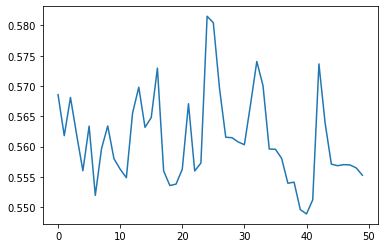

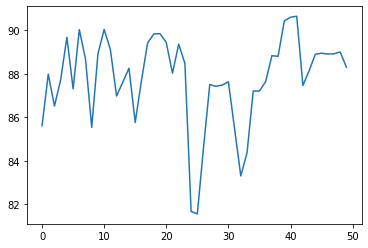

[85.61320754716981, 87.98113207547169, 86.51886792452831, 87.72641509433963, 89.67924528301887, 87.31132075471699, 90.02830188679245, 88.66981132075472, 85.5377358490566, 88.91509433962264, 90.0377358490566, 89.11320754716981, 86.98113207547169, 87.61320754716981, 88.25471698113208, 85.76415094339623, 87.67924528301887, 89.41509433962264, 89.83018867924528, 89.83962264150944, 89.43396226415095, 88.02830188679245, 89.35849056603773, 88.47169811320755, 81.67924528301887, 81.56603773584905, 84.62264150943396, 87.5, 87.4245283018868, 87.48113207547169, 87.63207547169812, 85.47169811320755, 83.31132075471699, 84.36792452830188, 87.20754716981132, 87.20754716981132, 87.64150943396227, 88.83018867924528, 88.80188679245283, 90.4245283018868, 90.59433962264151, 90.64150943396227, 87.4622641509434, 88.14150943396227, 88.89622641509433, 88.94339622641509, 88.90566037735849, 88.91509433962264, 89.0, 88.30188679245283]
[0.5685692350819426, 0.5617972935708064, 0.5681112869730536, 0.5619203316153221,

In [122]:
trained_model=train_model(train_dl,model,epochs=50,lr=1e-5)
print(final_train_accuracy_list)
print(final_train_loss_list)

In [123]:
# Testing Model
import math
final_test_loss_list=[]
final_test_accuracy_list = []
def test_model(test_dl, model,epochs=50, beta=0.2):
    preds = []
    loss_function = nn.BCEWithLogitsLoss()
    actuals = []
    test_loss_list=[]
    test_accuracy_list=[]
    
    model.eval()
    for epoch in tqdm(range(epochs)):
      running_test_loss=0.0
      running_test_accuracy = 0.0
      with torch.no_grad():
        for (i, (inputs, targets)) in tqdm(enumerate(test_dl)):
            #Evaluate the model on the test set
            inputs,targets = inputs.to(device),targets.to(device)
            # print(i)
            predicted_output = model(inputs)
            y_pred_tag = torch.round(predicted_output)
            # print(y_pred_tag)
            preds.append(y_pred_tag.cpu().detach().numpy())
            #Retrieve a numpy weights array
            # yhat = yhat.detach().numpy()
            test_los = loss_function(predicted_output, targets)
            # loss.backward()
            # print(loss)
            # print(targets.shape)
            test_acc= binary_acc(predicted_output, targets).item()
            # Extract the weights using detach to get the numerical values in an ndarray, instead of tensor
            actual = targets.cpu().numpy()
            actual = actual.reshape((len(actual), 1))
            acc = (predicted_output.reshape(-1).detach().numpy().round() == actual).mean()
            # Round to get the class value i.e. sick vs not sick
            # yhat = yhat.round()
            # Store the predictions in the empty lists initialised at the start of the class
            # preds.append(yhat)
            actuals.append(actual)
            test_acc=accuracy_score(actual,y_pred_tag.cpu().detach().numpy())
            running_test_accuracy+=test_acc
            # print("Loss: {}".format(test_los.item()))

            running_test_loss+=test_los.item()
        test_loss_value = running_test_loss/len(test_dl) 
        test_accuracy_value =running_test_accuracy/len(test_dl) 
        print(f'Epoch {epoch+0:03}: | Loss: {test_loss_value:.5f} | Acc: {test_accuracy_value:.3f}')
        print('Epoch {}/{} and Last loss: {} and Last Accuracy: {} and train_loss_value: {}'.format(epoch+1, epochs,test_los.item(),test_acc,test_loss_value))
        test_loss_list.append(test_loss_value)
        test_accuracy_list.append(test_accuracy_value)
    plt.plot(test_loss_list)
    plt.show()
    plt.plot(test_accuracy_list)
    plt.show()
    final_test_accuracy_list.extend(test_accuracy_list)
    final_test_loss_list.extend(test_loss_list)
    # Stack the predictions and actual arrays vertically
    preds, actuals = vstack(preds), vstack(actuals)
    #Calculate metrics
    y_pred_list = [a.squeeze().tolist() for a in preds]
    #flattens the lists in sequence
    ytest_pred = list(itertools.chain.from_iterable(preds))
    cm = confusion_matrix(actuals, preds)
    # Get descriptions of tp, tn, fp, fn
    tn, fp, fn, tp = cm.ravel()
    total = sum(cm.ravel())
    
    metrics = {
        'accuracy': accuracy_score(actuals, preds),
        'AU_ROC': roc_auc_score(actuals, preds),
        'f1_score': f1_score(actuals, preds),
        'average_precision_score': average_precision_score(actuals, preds),
        'f_beta': ((1+beta**2) * precision_score(actuals, preds) * recall_score(actuals, preds)) / (beta**2 * precision_score(actuals, preds) + recall_score(actuals, preds)),
        # 'matthews_correlation_coefficient': (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)),
        'precision': precision_score(actuals, preds),
        'recall': recall_score(actuals, preds),
        'true_positive_rate_TPR':recall_score(actuals, preds),
        'false_positive_rate_FPR':fp / (fp + tn) ,
        'false_discovery_rate': fp / (fp +tp),
        'false_negative_rate': fn / (fn + tp) ,
        'negative_predictive_value': tn / (tn+fn),
        'misclassification_error_rate': (fp+fn)/total ,
        'sensitivity': tp / (tp + fn),
        'specificity': tn / (tn + fp),
        #'confusion_matrix': confusion_matrix(actuals, preds), 
        'TP': tp,
        'FP': fp, 
        'FN': fn, 
        'TN': tn
    }
    return metrics, preds, actuals


In [124]:
results=test_model(test_loader, model, epochs=50,beta=1)
model_metrics = results[0]
metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['Value'])
metrics_df.index.name = 'Metrics_Name'
metrics_df.reset_index(inplace=True)
metrics_df


# Model , Optimizer, Loss
# model = Net(input_shape=x.shape[1]).to()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# loss_fn = nn.BCELoss()

# #forward loop
# losses = []
# accur = [] 
# for i in range(epochs):
#   for j,(x_train,y_train) in enumerate(trainloader):
    
#     #calculate output
#     output = model(x_train)
 
#     #calculate loss
#     loss = loss_fn(output,y_train.reshape(-1,1))
 
#     #accuracy
#     predicted = model(torch.tensor(x.values,dtype=torch.float32))
#     acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
#     #backprop
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#   if i%50 == 0:
#     losses.append(loss)
#     accur.append(acc)
#     print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

# # train_dataloader = DataLoader(data_line, batch_size=64, shuffle=True)
# # test_dataloader = DataLoader(data_line, batch_size=64, shuffle=True)
# # # dataloader.batch_size
# # # for sample in dataloader:
# # #     print(sample)

# # for i in range(len(train_dataloader)):
# #     sample = train_dataloader[i]

#     print(i, sample['image'].size(), sample['landmarks'].size())

#     if i == 3:
#         break

# loss_func = nn.BCELoss()
# #Optimizer
# learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# epochs = 50

# model.train()
# train_loss = []
# for epoch in range(epochs):
#     #Within each epoch run the subsets of data = batch sizes.
#     for xb, yb in train_dl:
#         y_pred = model(xb)            # Forward Propagation
#         loss = loss_func(y_pred, yb)  # Loss Computation
#         optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
#         loss.backward()               # Back Propagation
#         optimizer.step()              # Updating the parameters 
#     #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
#     train_loss.append(loss.item())
# print('Last iteration loss value: '+str(loss.item()))
# plt.plot(train_loss)
# plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]
0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
print(final_test_accuracy_list)
print(final_test_loss_list)
print(final_train_loss_list)
print(final_train_accuracy_list)
print(len(final_train_accuracy_list))
print(len(final_test_accuracy_list))
fig = plt.figure()

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


ax1.plot( final_train_accuracy_list, label="train_accuracy")
ax1.plot(final_test_accuracy_list, label="test_accuracy")
ax1.legend(loc=2)
ax2.plot(final_train_loss_list, label="train_loss")
ax2.plot(final_test_loss_list, label="test_loss")
ax2.legend(loc=2)
# plt.plot(final_train_accuracy_list,final_test_accuracy_list)
plt.show()